In [1]:
import os
import time

import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt

As mentioned in the paper we apply random jittering and mirroring to the training dataset.

- In random jittering, the image is resized to 286 x 286 and then randomly cropped to 256 x 256
- In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [2]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin = _URL,
                                      extract = True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

30171136/30168306 [==============================] - 11s 0us/step


In [3]:
# Params

BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [4]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

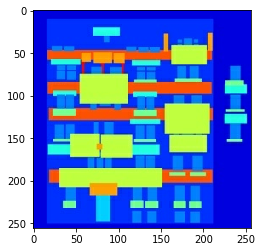

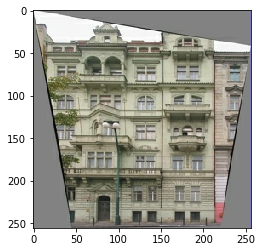

In [5]:
inp, re = load(PATH + 'train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [6]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [7]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis = 0)
  cropped_image = tf.image.random_crop(
      stacked_image, size = [2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [8]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [9]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

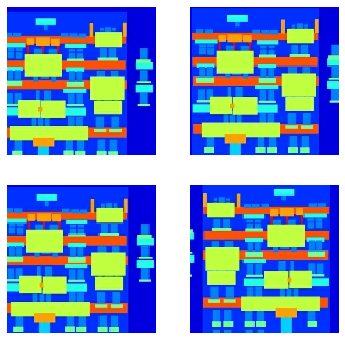

In [10]:
plt.figure(figsize = (6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [11]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [12]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [13]:
train_dataset = tf.data.Dataset.list_files(PATH + 'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [14]:
test_dataset = tf.data.Dataset.list_files(PATH + 'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)